In [2]:
import numpy as np
import scipy.signal as sig
import cv2
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

def plot_ff(F):
    return np.log(np.abs(np.fft.fftshift(F)))

Markdown(r'# LEC 6: Frequency Domain Filters')

# LEC 6: Frequency Domain Filters

## Example 1

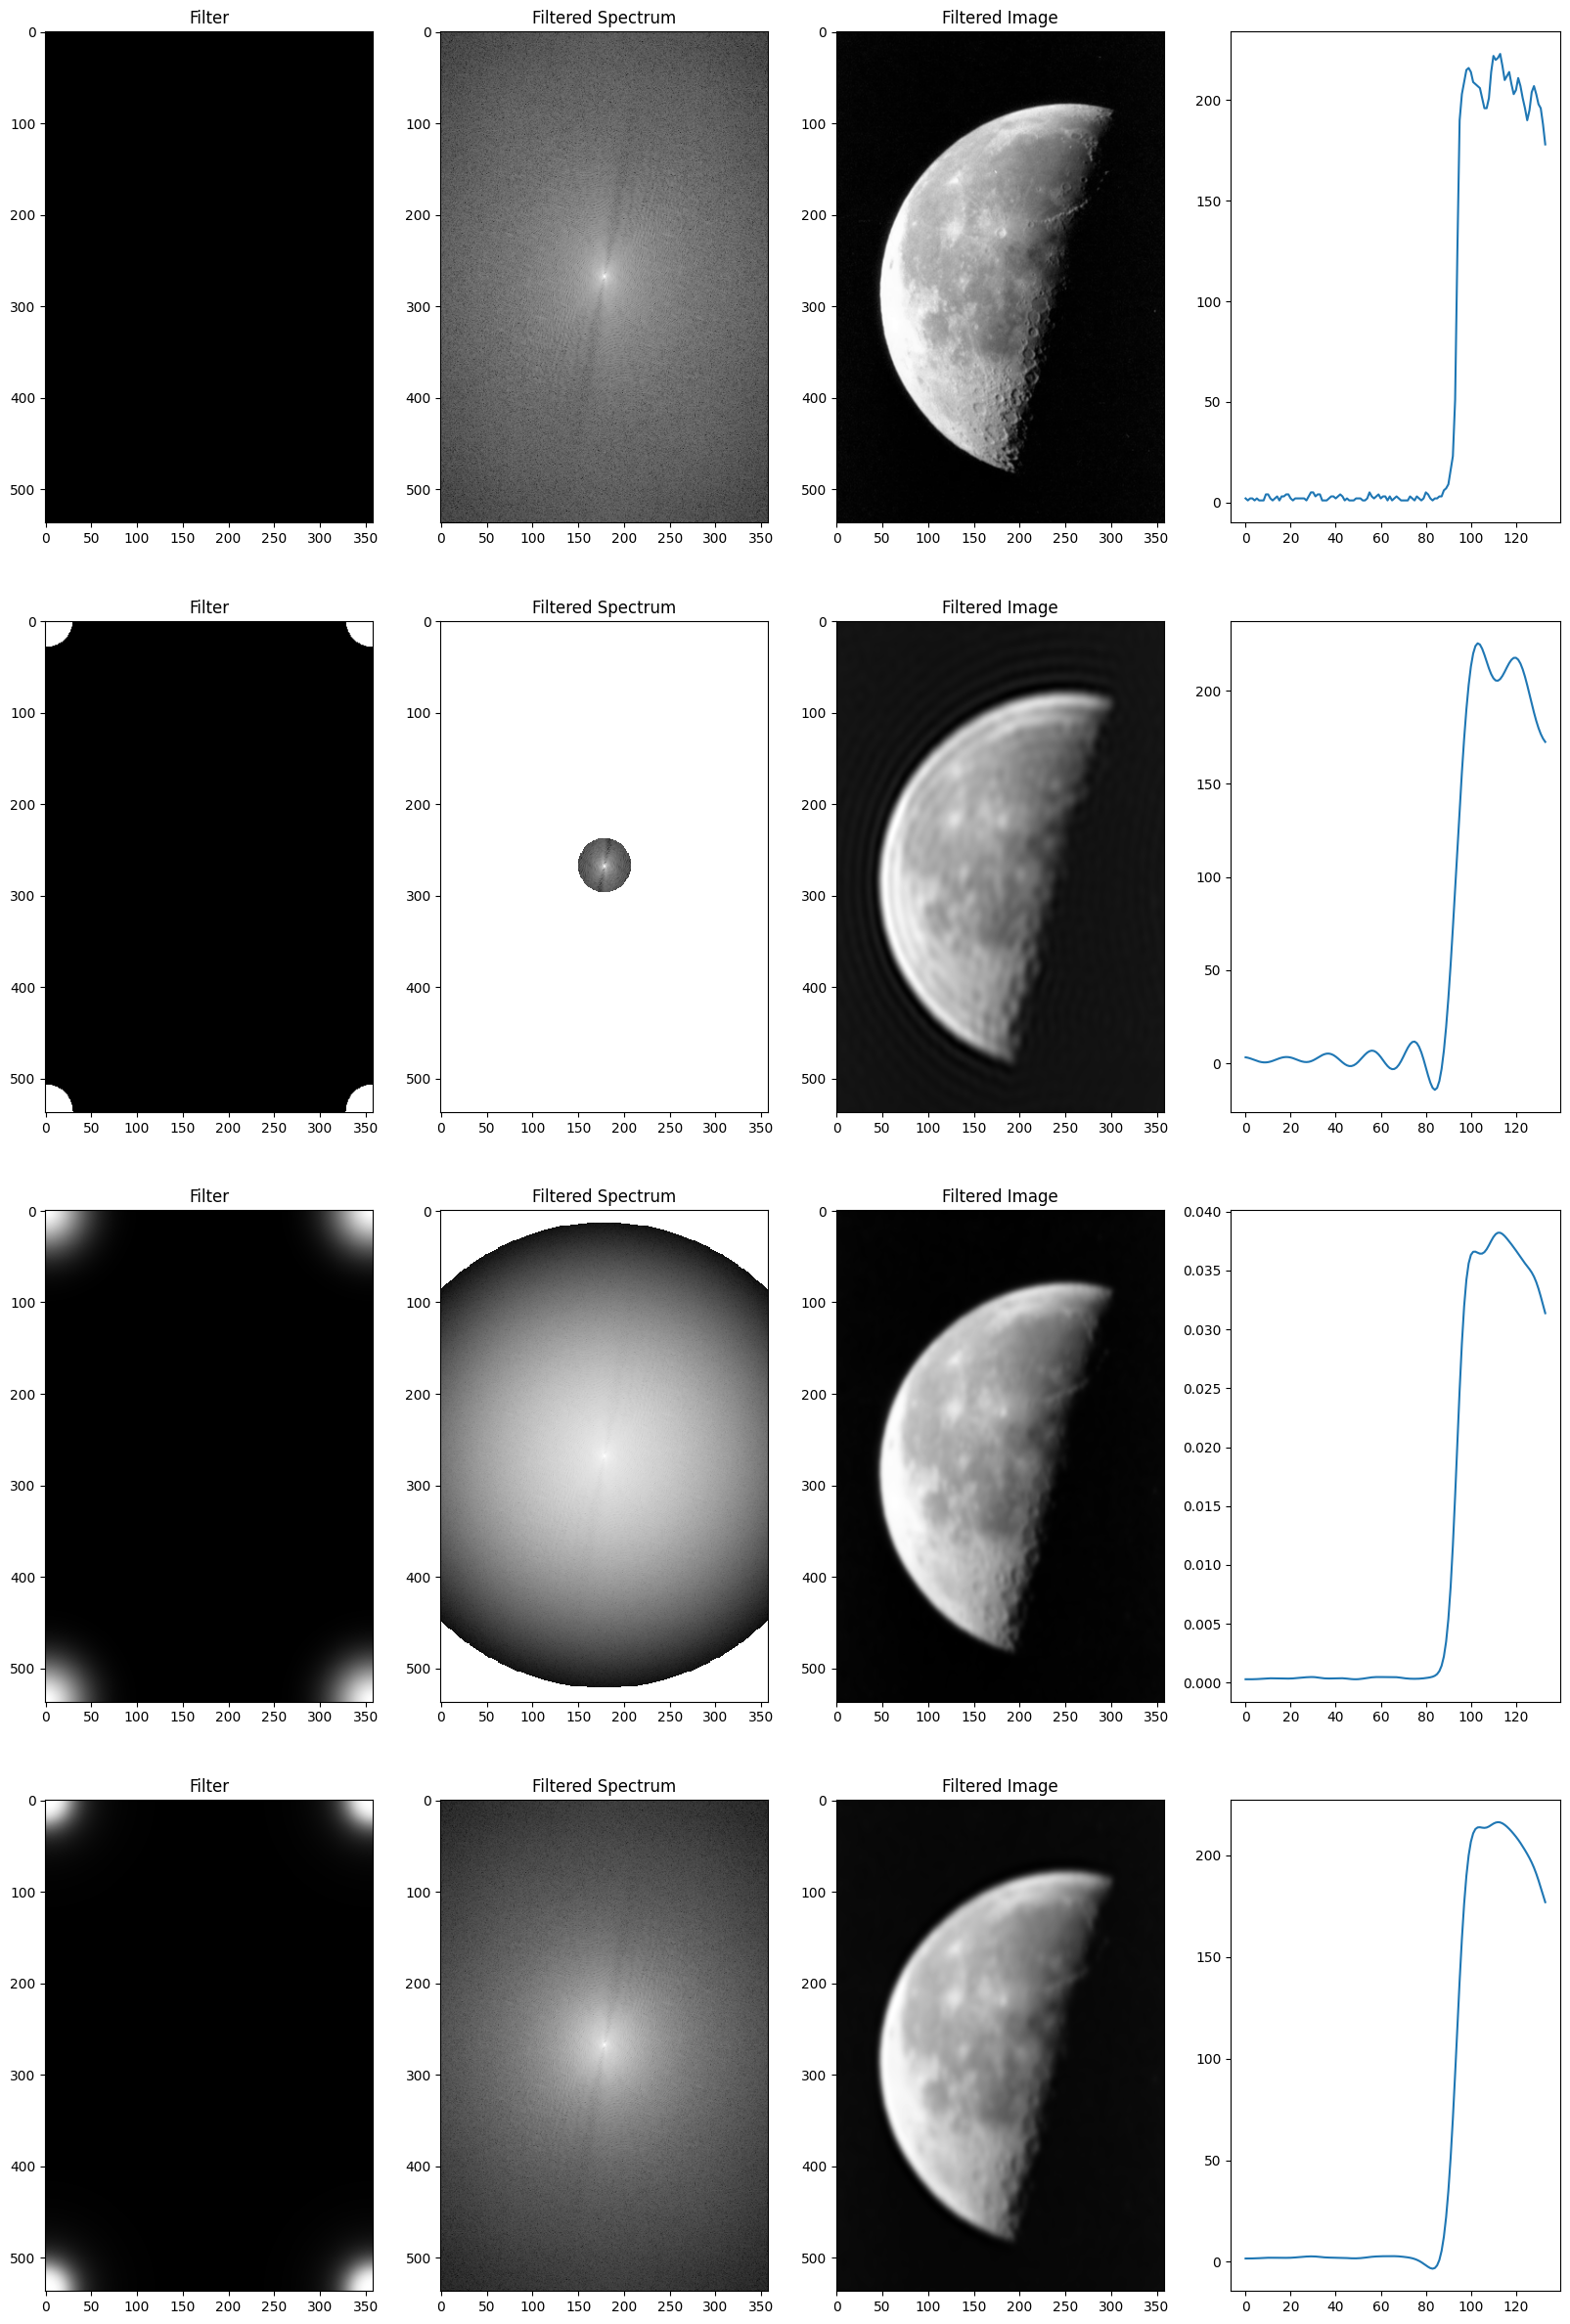

In [3]:
%matplotlib inline
display(Markdown(r'## Example 1'))
np.seterr(divide='ignore', invalid='ignore')

def gkern(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

R = 30
n = 2
img = cv2.imread('moon.tif', cv2.IMREAD_GRAYSCALE).astype(np.float64)

ideal = np.zeros_like(img)
ideal = cv2.circle(ideal, (img.shape[1]//2, img.shape[0]//2), R, 1, -1)
ideal = np.fft.fftshift(ideal)

gaus = gkern(img.shape, R)
gaus = np.fft.fftshift(gaus)


U, V = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
U -= img.shape[1]//2
V -= img.shape[0]//2
D = np.sqrt(U**2 + V**2)
butt = 1/(1 + (D/R)**(2*n))
butt = np.fft.fftshift(butt)

fig, ax = plt.subplots(4, 4, figsize=(20, 30))

for i, filter in enumerate([np.ones_like(img), ideal, gaus, butt]):
    F = np.fft.fft2(img)
    F = F*filter
    filtered_img = np.fft.ifft2(F)
    filtered_img = np.real(filtered_img)
    ax[i, 0].imshow(filter, cmap='gray')
    ax[i, 1].imshow(plot_ff(F), cmap='gray')
    ax[i, 2].imshow(filtered_img, cmap='gray')
    ax[i, 3].plot(filtered_img[:filtered_img.shape[0]//4, filtered_img.shape[1]//2])
    ax[i, 0].set_title('Filter')
    ax[i, 1].set_title('Filtered Spectrum')
    ax[i, 2].set_title('Filtered Image')

plt.show()


## Example 2

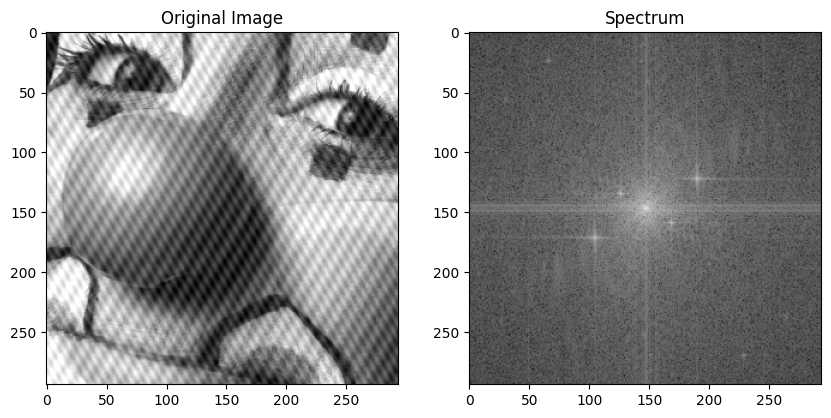

### $ F(0,0) = 12487072 \quad \sum_{u,v}^{H,W} img[u,v] = 12487072 $

#### thereby DC value of an image is equal to DFT of image in coordinate (0,0)

In [4]:
display(Markdown(r'## Example 2'))

img = cv2.imread('Clown.tif', cv2.IMREAD_GRAYSCALE).astype(np.float64)
F = np.fft.fft2(img)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(plot_ff(F), cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Spectrum')
plt.show()

display(Markdown(r'### $ F(0,0) = %d \quad \sum_{u,v}^{H,W} img[u,v] = %d $' % (np.real(F[0, 0]) , np.sum(img))))
display(Markdown(r'#### thereby DC value of an image is equal to DFT of image in coordinate (0,0)'))

## Example 3

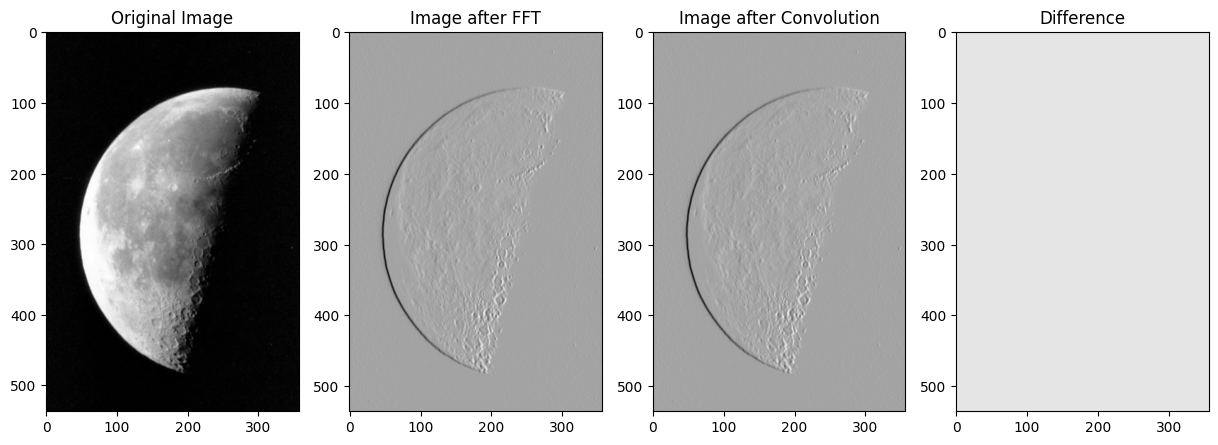

#### avg difference = -0.075651

In [5]:
%matplotlib inline
display(Markdown(r'## Example 3'))

img = cv2.imread('moon.tif', cv2.IMREAD_GRAYSCALE).astype(np.float64)

sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_padded = np.zeros_like(img)
sobel_padded[:sobel.shape[0], :sobel.shape[1]] = sobel

F = np.fft.fft2(img)
F_sobel = np.fft.fft2(sobel_padded)
img_fft = np.real(np.fft.ifft2(F*F_sobel))
img_fft[:-1, :-1] = img_fft[1:, 1:]
img_fft = img_fft[:-1, :-1]

img_sobel = sig.convolve2d(img, sobel, 'same')
img_sobel = img_sobel[:-1, :-1]

_, ax = plt.subplots(1, 4, figsize=(15, 5))


ax[0].imshow(img, cmap='gray')
ax[1].imshow(np.real(img_fft), cmap='gray')
ax[2].imshow(img_sobel, cmap='gray')
ax[3].imshow(img_sobel - img_fft, cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Image after FFT')
ax[2].set_title('Image after Convolution')
ax[3].set_title('Difference')
plt.show()

display(Markdown(r'#### avg difference = %f' % np.mean(img_sobel - img_fft)))


## Example 4

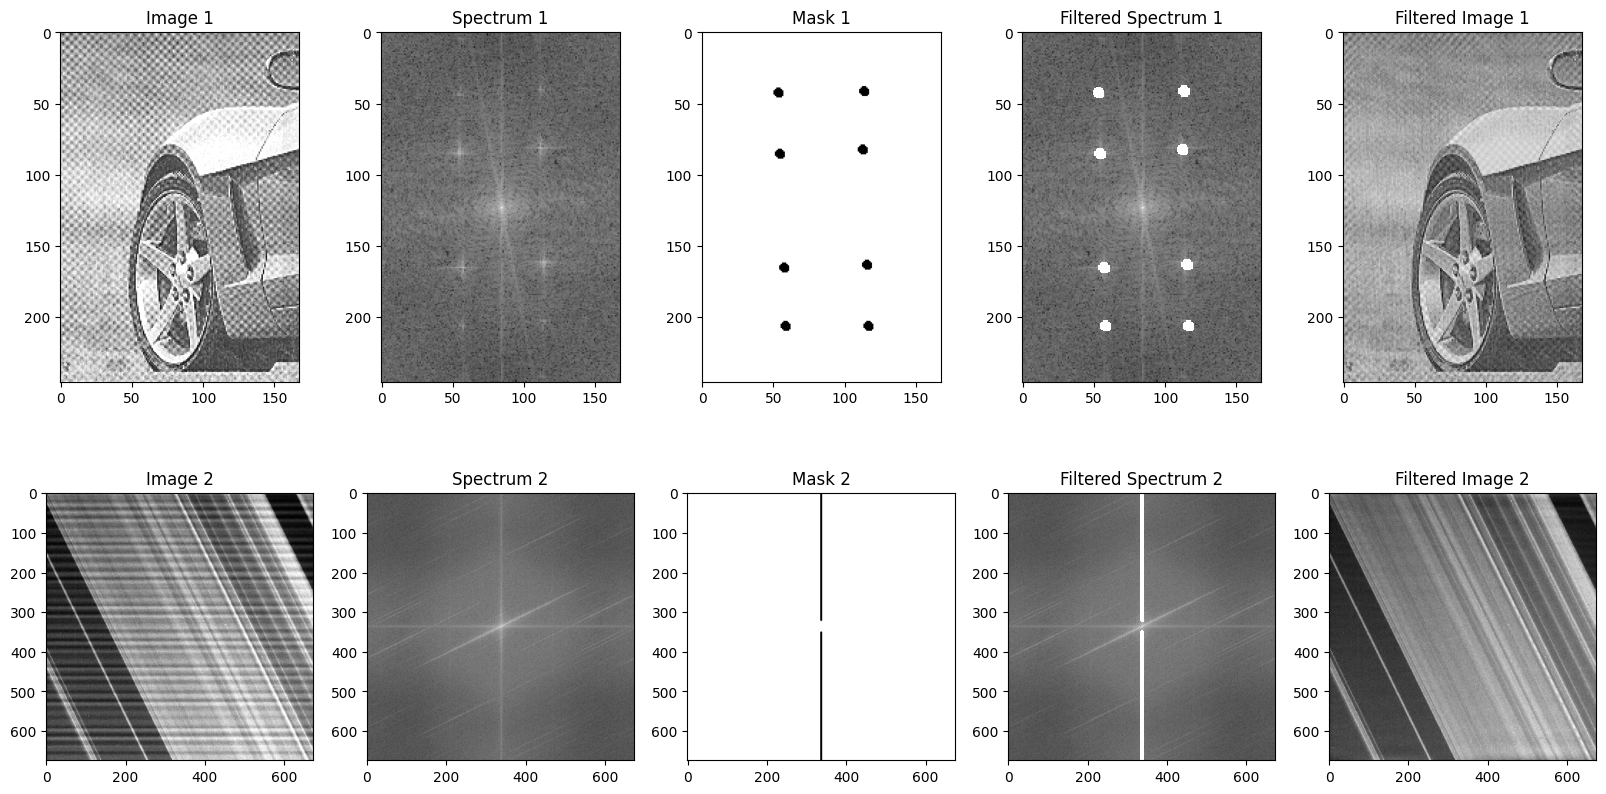

In [46]:
%matplotlib inline
display(Markdown(r'## Example 4'))

img_1 = cv2.imread('Fig0464(a).tif', cv2.IMREAD_GRAYSCALE).astype(np.float64)
img_2 = cv2.imread('Fig0465(a).tif', cv2.IMREAD_GRAYSCALE).astype(np.float64)

F_1 = np.fft.fft2(img_1)
F_2 = np.fft.fft2(img_2)

# cv2.imwrite('mask_1.png', plot_ff(F_1) / plot_ff(F_1).max() * 255)
mask_1 = cv2.imread('mask_1.png', cv2.IMREAD_GRAYSCALE).astype(np.float64) > 0

thickness = 3
width = 15
mask_2 = np.ones_like(img_2)
mask_2 = cv2.line(mask_2, (img_2.shape[0]//2, img_2.shape[1]), (img_2.shape[0]//2, img_2.shape[1]//2 + width), 0, thickness)
mask_2 = cv2.line(mask_2, (img_2.shape[0]//2, img_2.shape[1]//2 - width), (img_2.shape[0]//2, 0), 0, thickness)

_, ax = plt.subplots(2, 5, figsize=(20, 10))

ax[0, 0].imshow(img_1, cmap='gray')
ax[0, 1].imshow(plot_ff(F_1), cmap='gray')
ax[0, 2].imshow(mask_1, cmap='gray')
ax[0, 3].imshow(plot_ff(F_1*np.fft.fftshift(mask_1)), cmap='gray')
ax[0, 4].imshow(np.real(np.fft.ifft2(F_1*np.fft.fftshift(mask_1))), cmap='gray')
ax[0, 0].set_title('Image 1')
ax[0, 1].set_title('Spectrum 1')
ax[0, 2].set_title('Mask 1')
ax[0, 3].set_title('Filtered Spectrum 1')
ax[0, 4].set_title('Filtered Image 1')

ax[1, 0].imshow(img_2, cmap='gray')
ax[1, 1].imshow(plot_ff(F_2), cmap='gray')
ax[1, 2].imshow(mask_2, cmap='gray')
ax[1, 3].imshow(plot_ff(F_2*np.fft.fftshift(mask_2)), cmap='gray')
ax[1, 4].imshow(np.real(np.fft.ifft2(F_2*np.fft.fftshift(mask_2))), cmap='gray')
ax[1, 0].set_title('Image 2')
ax[1, 1].set_title('Spectrum 2')
ax[1, 2].set_title('Mask 2')
ax[1, 3].set_title('Filtered Spectrum 2')
ax[1, 4].set_title('Filtered Image 2')
plt.show()

## Example 5

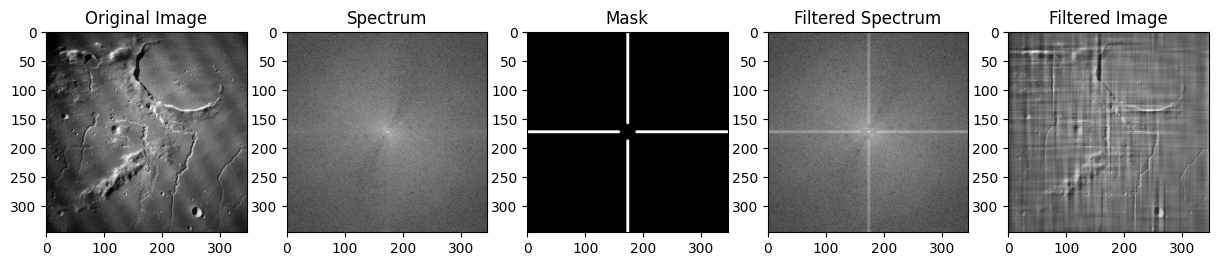

In [123]:
display(Markdown(r'## Example 5'))

img = cv2.imread('ripples.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64)
F = np.fft.fft2(img)
cv2.imwrite('mask.png', plot_ff(F) * 255 / max(plot_ff(F).flatten()))

# mask = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE).astype(np.float64) == 0
thickness = 3
width = 15
mask = np.zeros_like(img)
mask = cv2.line(mask, (0, img.shape[1]//2), (img.shape[0]//2 - width, img.shape[1]//2), 1, thickness)
mask = cv2.line(mask, (img.shape[0]//2 + width, img.shape[1]//2), (img.shape[0], img.shape[1]//2), 1, thickness)
mask = cv2.line(mask, (img.shape[0]//2, 0), (img.shape[0]//2, img.shape[1]//2 - width), 1, thickness)
mask = cv2.line(mask, (img.shape[0]//2, img.shape[1]//2 + width), (img.shape[0]//2, img.shape[1]), 1, thickness)
alpha = 5
mask_alphad = alpha*mask + 1

_, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(plot_ff(F), cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[3].imshow(plot_ff(F*np.fft.fftshift(mask_alphad)), cmap='gray')
ax[4].imshow(np.real(np.fft.ifft2(F*np.fft.fftshift(mask_alphad))), cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Spectrum')
ax[2].set_title('Mask')
ax[3].set_title('Filtered Spectrum')
ax[4].set_title('Filtered Image')
plt.show()

## Alpha Values

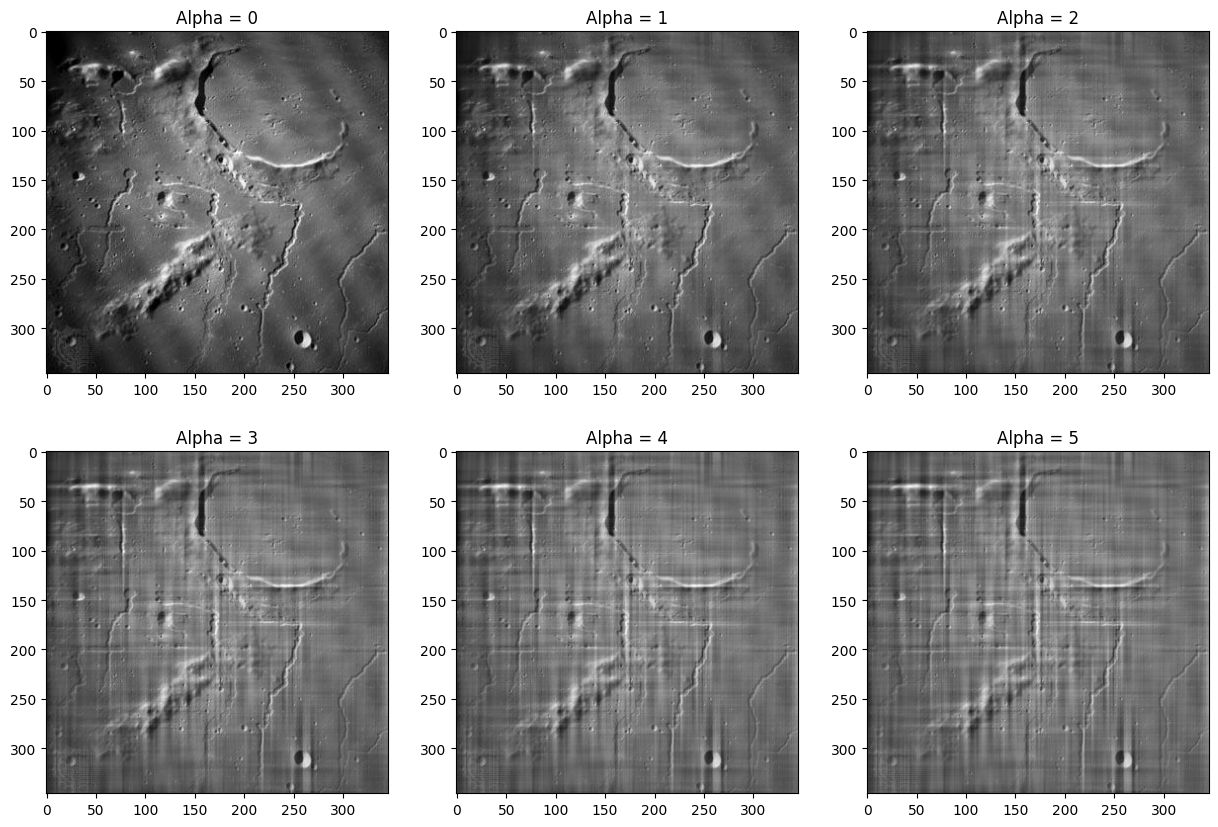

In [124]:
display(Markdown(r'## Alpha Values'))

_, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

for i in range(6):
    mask_alphad = i*mask + 1
    ax[i].imshow(np.real(np.fft.ifft2(F*np.fft.fftshift(mask_alphad))), cmap='gray')
    ax[i].set_title('Alpha = {}'.format(i))
plt.show()
